In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl

# ======
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
from functions.rnn_cryptic_equals import convert_seq2inputs, calculate_output, onehot2seq 

# Functions

In [2]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.000001)


def train(sequence, label ,model ,optimizer ,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs

def test_preds(model, testdata, hidden_size, suffix = ''):
    model.eval()
    preds = []
    labs = []
    trials = []
    accs = []
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                preds.append(y_hat.detach().item())
                labs.append(y[i].detach().item())
                correct = sum(torch.round(y[i]) == torch.round(y_hat)).item()
                accs.append(correct)
            trials.append(str(onehot2seq(x)))
    df = pd.DataFrame({'trial':trials, 'label'+suffix:labs, 'pred'+suffix: preds, 'acc'+suffix: accs})
    return df 


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

def run_sim(train_trials, test_trials):
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials, test_trials, epochs)
    return loss1, acc1, model

def run_sims(i, train_trials, test_trials):
    print('########## rep', i, '#########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials[0], test_trials, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, train_trials[1], test_trials, epochs)
    losses = np.vstack([loss1,loss2])
    accs = np.vstack([acc1,acc2])
    return losses, accs, model


def change_dict(seqs, new_dict):
    """ recalculates sequence output"""
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, new_dict))

    return inps

def predcorr(mods, tests, plot_corr = True):
    dfs1 = []
    for i in range(len(mods)):
        df = test_preds(mods[i], [tests[i]], hidden_size)
        dfs1.append(df)
    all_dfs1 = pd.concat(dfs1) 
    preds, labs = all_dfs1['pred'], all_dfs1['label']
    xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)
    r2_val = r2_score(all_dfs1['pred'],all_dfs1['label'])
    df_fin = all_dfs1.groupby(['trial']).mean().sort_values(by = 'acc' , ascending=False)
    if plot_corr:
        for d in dfs1:
            plt.scatter(d['label'], d['pred'])
        plt.plot(xy,xy)
        plt.xlabel('Ground truth')
        plt.ylabel('Model prediction')
        plt.title('with primitive training, R^2 = ' + str(round(r2_val, 2)) )
             
    return r2_val, df_fin, all_dfs1  

# -----------------
# Generating trials
# -----------------

def generate_primitives(inputs):
    seq = []
    for inp in inputs:
        trial = [inp, '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq


def generate_trials(op, input_ids, init_values):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat=1))
    for init in init_values:
        for cue in combi_inputcue:
            seq.append([init,
                        *zip(tuple(op), cue), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq

def generate_self(op, inputs):
    seq = []
    for inp in inputs:
        trial = generate_trials(op, inp, inp)
        seq += trial
    return seq

def generate_other(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other_reverse(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other_reverse_primitives(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    n = int(len(inputs1)/2)
    for i in range(n):
        trial = [inputs1[i], (op, inputs2[i+n]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

# ----------
# plotting
# ----------

def plotNNs(loss_arrays, acc_arrays, labels, colors, title, shift = 0):

    fig, axs = plt.subplots(2, 1)
    loss_cols = ['blue', 'darkblue']
    loss_labs = ['loss_with_primitive', 'loss_without_primitive']
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[0].plot(x, mn, label = loss_labs[i], color = loss_cols[i])
        axs[0].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = loss_cols[i])
    
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend()
    
    for i, arr in enumerate(acc_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[1].plot(x, mn, label = labels[i], color = colors[i])
        axs[1].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()

    fig.suptitle(title, fontsize=10)
    
def heatmap_acc(num_inputs, df, ax):
    
    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    map_syms = total_syms[:num_inputs]
    data_accs = np.empty((num_inputs, num_inputs))
    data_accs[:] = np.NaN
    for r, trial in enumerate(df.index):
        i = map_syms.index(eval(trial)[0])
        j = map_syms.index(eval(trial)[2])
        acc = round(df.iloc[r]['acc'], 2)
        data_accs[i,j] = acc
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(num_inputs), labels=map_syms)
    ax.set_yticks(np.arange(num_inputs), labels=map_syms)

    #cmap = mpl.colors.ListedColormap(['yellow', 'orange', 'darkorange','red'])
    from matplotlib import cm
    new_reds = cm.get_cmap('Reds', 10)
    cmap=new_reds
    bounds = list(np.arange(0,1.1,0.1))
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    im = ax.imshow(data_accs, cmap=cmap, norm=norm)

    # Loop over data dimensions and create text annotations.
    for i in range(num_inputs):
        for j in range(num_inputs):
            if np.isnan(data_accs[i, j]):
                pass
            else:
                text = ax.text(j,i, data_accs[i, j],
                              ha="center", va="center", color="black", fontsize=12)


# RNN setup

In [3]:
## running function

def run_exp(trainseqs_old, testseqs_old, cue_dict):

    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load data for primitive training
    trainseqs = change_dict(trainseqs_old, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    testseqs = change_dict(testseqs_old, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)
    
    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test': testset}

def run_plot(trainseqs, testseqs, cue_dict):
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs, testseqs, cue_dict) for i in range(num_sims))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)

    losses = np.hstack([r['loss'] for r in res])
    acc_train = np.array([r['acc'][:,0] for r in res]).T
    acc_test = np.array([r['acc'][:,1] for r in res]).T
    mods = [r['mod'] for r in res]
    tests = [r['test'] for r in res]

    plotNNs([losses], [acc_train, acc_test], \
            ['train', 'test'], colors = ['green', 'orange'], title = '', shift = 0)
    
    final_accs = pd.DataFrame({'train_acc': acc_train[-1,:],'test_acc': acc_test[-1,:]}) 
    
    fully_trained = final_accs[final_accs['train_acc'] == 1]
    fully_trained_idx = fully_trained.index
    fully_trained_test_acc = fully_trained['test_acc'].mean() 
    fully_trained_test_acc_std = fully_trained['test_acc'].std()
    
    ft_mods = [mods[i] for i in fully_trained_idx]
    print(len(ft_mods))
    ft_tests = [tests[i] for i in fully_trained_idx]
    if len(ft_mods) > 0:
        plt.figure()
        r2, dfs, alldfs = predcorr(ft_mods, ft_tests, plot_corr = False)
    else:
        r2, dfs, alldfs = 0, 0, 0

    t3 = time.time()
    print('total time: ', (t3-t1)/60)
    print(fully_trained.shape[0], '/', final_accs.shape[0], ' rnns trained to 100% accuracy.\
        \n Mean test acc = ', round(fully_trained_test_acc, 2),  '\n-----------\n')

    return {'res':res, 'r2': r2, 'all_final_accs': final_accs, 'mean_acc_final': fully_trained_test_acc,\
            'all_dfs':alldfs, 'df_trials': dfs, 'acc_std': fully_trained_test_acc_std}

def run_self_other(num_inputs, p=[]):

    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    all_syms = total_syms[:num_inputs]
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    cue_dict = {}
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]

    num_other = list(range(0, num_inputs+1))
    num_other.remove(1)

    all_r2s = []
    all_accs = []
    all_reses = []
    all_acc_std = []
    for i in range(len(num_other)):
        n_other = num_other[i]
        print('no. other trials = ', n_other, ';  no. self: ', num_inputs - n_other)
        self_trials = []
        other_trials = []
        if n_other != num_inputs:
            self_trials = generate_self(ops, all_syms[n_other:])
        if n_other != 0:
            other_trials = generate_other(ops, all_syms[:n_other])

        trainseqs = self_trials + other_trials + p
        testseqs = generate_trials(ops, all_syms, all_syms)
        testseqs = [t for t in testseqs if t not in trainseqs]
        print('trainseqs: ', trainseqs)
        print('testseqs: ', testseqs)
        res = run_plot(trainseqs, testseqs, cue_dict)
        all_r2s.append(res['r2'])
        all_accs.append(res['mean_acc_final'])
        all_acc_std.append(res['acc_std'])
        all_reses.append(res)
        
    return all_reses, np.array(all_accs), all_r2s, np.array(all_acc_std)


In [5]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 1200
num_sims = 104

# Experiments

Final accuracy against ratio of other/self



In [7]:
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
p = generate_primitives(all_syms)
print(p)

{'A': 4, 'B': 6, 'C': 7, 'D': 9}
[['A', '=', 4], ['B', '=', 6], ['C', '=', 7], ['D', '=', 9]]


# 1 train trial

In [109]:
a1 = np.empty((0,20))
np.vstack([a1, np.ones(20)]).shape

(1, 20)

In [105]:
# self
trainseqs = generate_self(ops, ['A'])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res1 = run_plot(trainseqs, testseqs, cue_dict)
df1 = res1['df_trials']
df1

trainseqs  [['A', ('+', 'A'), '=', 8], ['A', '=', 4], ['B', '=', 6], ['C', '=', 7], ['D', '=', 9]]
testseqs  [['A', ('+', 'B'), '=', 10], ['A', ('+', 'C'), '=', 11], ['A', ('+', 'D'), '=', 13], ['B', ('+', 'A'), '=', 10], ['B', ('+', 'B'), '=', 12], ['B', ('+', 'C'), '=', 13], ['B', ('+', 'D'), '=', 15], ['C', ('+', 'A'), '=', 11], ['C', ('+', 'B'), '=', 13], ['C', ('+', 'C'), '=', 14], ['C', ('+', 'D'), '=', 16], ['D', ('+', 'A'), '=', 13], ['D', ('+', 'B'), '=', 15], ['D', ('+', 'C'), '=', 16], ['D', ('+', 'D'), '=', 18]]


KeyboardInterrupt: 

trainseqs  [['A', ('+', 'B'), '=', 10], ['A', '=', 4], ['B', '=', 6], ['C', '=', 7], ['D', '=', 9]]
testseqs  [['A', ('+', 'A'), '=', 8], ['A', ('+', 'C'), '=', 11], ['A', ('+', 'D'), '=', 13], ['B', ('+', 'A'), '=', 10], ['B', ('+', 'B'), '=', 12], ['B', ('+', 'C'), '=', 13], ['B', ('+', 'D'), '=', 15], ['C', ('+', 'A'), '=', 11], ['C', ('+', 'B'), '=', 13], ['C', ('+', 'C'), '=', 14], ['C', ('+', 'D'), '=', 16], ['D', ('+', 'A'), '=', 13], ['D', ('+', 'B'), '=', 15], ['D', ('+', 'C'), '=', 16], ['D', ('+', 'D'), '=', 18]]
run time:  3.647123332818349
89
total time:  3.6573348681132
89 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.16 
-----------



,label,pred,acc
trial,,,
"['A', '+', 'C', '=']",18.370787,18.220678,0.741573
"['A', '+', 'A', '=']",18.022472,17.746022,0.719101
"['A', '+', 'D', '=']",18.595506,18.513591,0.674157
"['B', '+', 'C', '=']",18.483146,24.926898,0.044944
"['C', '+', 'A', '=']",18.370787,25.508885,0.044944
"['B', '+', 'D', '=']",18.707865,25.187195,0.033708
"['C', '+', 'C', '=']",18.719101,25.972565,0.033708
"['D', '+', 'A', '=']",18.595506,26.314071,0.033708
"['D', '+', 'C', '=']",18.943820,26.731962,0.033708


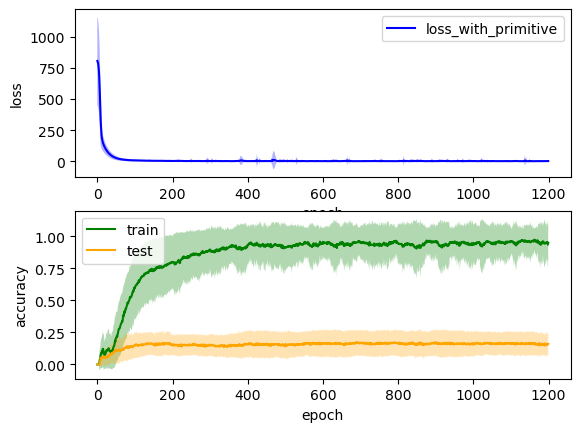

<Figure size 640x480 with 0 Axes>

In [12]:
# other
trainseqs = generate_trials(ops, ['B'],['A'])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res2 = run_plot(trainseqs, testseqs, cue_dict)
df2 = res2['df_trials']
df2

# 2 train trials

trainseqs  [['A', ('+', 'A'), '=', 8], ['B', ('+', 'A'), '=', 10], ['A', '=', 4], ['B', '=', 6], ['C', '=', 7], ['D', '=', 9]]
testseqs  [['A', ('+', 'B'), '=', 10], ['A', ('+', 'C'), '=', 11], ['A', ('+', 'D'), '=', 13], ['B', ('+', 'B'), '=', 12], ['B', ('+', 'C'), '=', 13], ['B', ('+', 'D'), '=', 15], ['C', ('+', 'A'), '=', 11], ['C', ('+', 'B'), '=', 13], ['C', ('+', 'C'), '=', 14], ['C', ('+', 'D'), '=', 16], ['D', ('+', 'A'), '=', 13], ['D', ('+', 'B'), '=', 15], ['D', ('+', 'C'), '=', 16], ['D', ('+', 'D'), '=', 18]]
run time:  6.4949114998181665
81
total time:  6.509509817759196
81 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.66 
-----------



,label,pred,acc
trial,,,
"['A', '+', 'C', '=']",18.333333,18.021286,0.777778
"['A', '+', 'D', '=']",18.000000,17.768224,0.777778
"['B', '+', 'C', '=']",19.012346,18.571916,0.777778
"['B', '+', 'D', '=']",18.679012,18.371288,0.777778
"['C', '+', 'A', '=']",18.333333,18.137273,0.777778
"['B', '+', 'B', '=']",19.555556,19.073856,0.765432
"['A', '+', 'B', '=']",18.876543,18.550817,0.753086
"['D', '+', 'A', '=']",18.000000,17.760275,0.691358
"['C', '+', 'D', '=']",18.135802,17.614992,0.592593


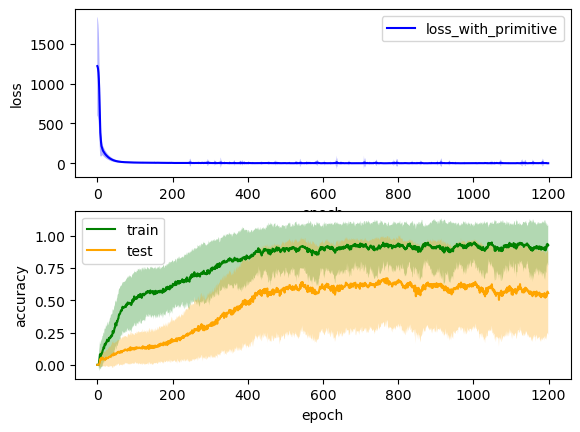

<Figure size 640x480 with 0 Axes>

In [15]:
# row
trainseqs = generate_trials(ops, ['A'], ['A', 'B'])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res3 = run_plot(trainseqs, testseqs, cue_dict)
df3 = res3['df_trials']
df3

trainseqs  [['A', ('+', 'A'), '=', 8], ['A', ('+', 'B'), '=', 10], ['A', '=', 4], ['B', '=', 6], ['C', '=', 7], ['D', '=', 9]]
testseqs  [['A', ('+', 'C'), '=', 11], ['A', ('+', 'D'), '=', 13], ['B', ('+', 'A'), '=', 10], ['B', ('+', 'B'), '=', 12], ['B', ('+', 'C'), '=', 13], ['B', ('+', 'D'), '=', 15], ['C', ('+', 'A'), '=', 11], ['C', ('+', 'B'), '=', 13], ['C', ('+', 'C'), '=', 14], ['C', ('+', 'D'), '=', 16], ['D', ('+', 'A'), '=', 13], ['D', ('+', 'B'), '=', 15], ['D', ('+', 'C'), '=', 16], ['D', ('+', 'D'), '=', 18]]
run time:  7.052768580118815
96
total time:  7.070491814613343
96 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.16 
-----------



,label,pred,acc
trial,,,
"['A', '+', 'D', '=']",18.625000,18.568712,0.875000
"['A', '+', 'C', '=']",18.093750,18.003388,0.854167
"['D', '+', 'A', '=']",18.625000,25.876157,0.072917
"['D', '+', 'B', '=']",20.354167,27.616099,0.072917
"['D', '+', 'C', '=']",19.781250,26.965245,0.062500
"['D', '+', 'D', '=']",20.312500,27.546460,0.062500
"['C', '+', 'C', '=']",19.250000,27.320561,0.052083
"['C', '+', 'A', '=']",18.093750,26.182078,0.041667
"['C', '+', 'B', '=']",19.822917,27.906806,0.041667


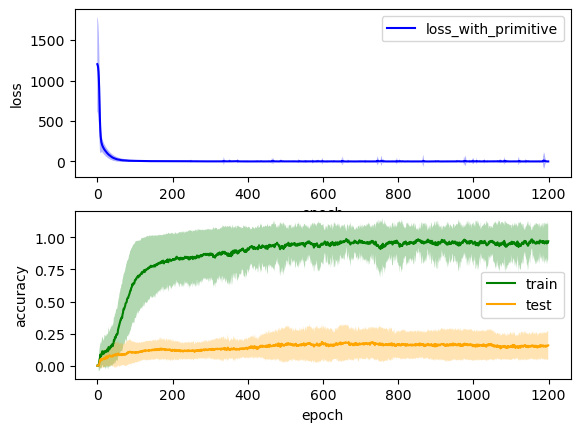

<Figure size 640x480 with 0 Axes>

In [16]:
# col
trainseqs = generate_trials(ops, ['A', 'B'], ['A'])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res4 = run_plot(trainseqs, testseqs, cue_dict)
df4 = res4['df_trials']
df4

trainseqs  [['A', ('+', 'A'), '=', 8], ['B', ('+', 'B'), '=', 12], ['A', '=', 4], ['B', '=', 6], ['C', '=', 7], ['D', '=', 9]]
testseqs  [['A', ('+', 'B'), '=', 10], ['A', ('+', 'C'), '=', 11], ['A', ('+', 'D'), '=', 13], ['B', ('+', 'A'), '=', 10], ['B', ('+', 'C'), '=', 13], ['B', ('+', 'D'), '=', 15], ['C', ('+', 'A'), '=', 11], ['C', ('+', 'B'), '=', 13], ['C', ('+', 'C'), '=', 14], ['C', ('+', 'D'), '=', 16], ['D', ('+', 'A'), '=', 13], ['D', ('+', 'B'), '=', 15], ['D', ('+', 'C'), '=', 16], ['D', ('+', 'D'), '=', 18]]
run time:  6.366764481862386
83
total time:  6.375994618733724
83 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.61 
-----------



,label,pred,acc
trial,,,
"['B', '+', 'A', '=']",18.204819,18.331903,0.867470
"['A', '+', 'B', '=']",18.204819,18.153579,0.843373
"['A', '+', 'C', '=']",19.771084,19.706320,0.771084
"['B', '+', 'C', '=']",19.349398,19.361530,0.771084
"['A', '+', 'D', '=']",17.578313,17.451416,0.710843
"['B', '+', 'D', '=']",17.156627,17.110550,0.710843
"['C', '+', 'A', '=']",19.771084,20.838570,0.554217
"['C', '+', 'B', '=']",19.349398,20.312807,0.554217
"['D', '+', 'A', '=']",17.578313,18.806166,0.530120


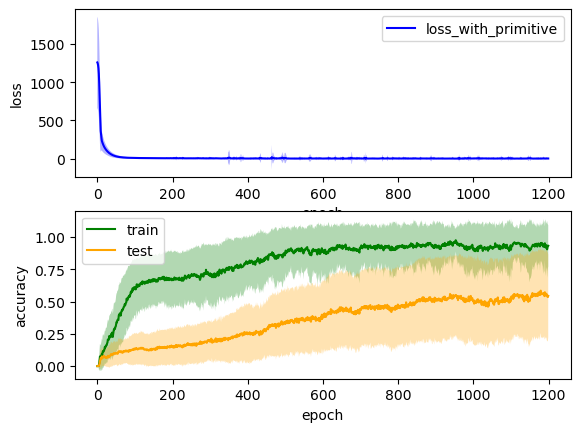

<Figure size 640x480 with 0 Axes>

In [17]:
# self
trainseqs = generate_self(ops, ['A', 'B'])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res5 = run_plot(trainseqs, testseqs, cue_dict)
df5 = res5['df_trials']
df5

trainseqs  [['A', ('+', 'B'), '=', 10], ['B', ('+', 'A'), '=', 10], ['A', '=', 4], ['B', '=', 6], ['C', '=', 7], ['D', '=', 9]]
testseqs  [['A', ('+', 'A'), '=', 8], ['A', ('+', 'C'), '=', 11], ['A', ('+', 'D'), '=', 13], ['B', ('+', 'B'), '=', 12], ['B', ('+', 'C'), '=', 13], ['B', ('+', 'D'), '=', 15], ['C', ('+', 'A'), '=', 11], ['C', ('+', 'B'), '=', 13], ['C', ('+', 'C'), '=', 14], ['C', ('+', 'D'), '=', 16], ['D', ('+', 'A'), '=', 13], ['D', ('+', 'B'), '=', 15], ['D', ('+', 'C'), '=', 16], ['D', ('+', 'D'), '=', 18]]
run time:  5.023652382691702
94
total time:  5.036257863044739
94 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.63 
-----------



,label,pred,acc
trial,,,
"['A', '+', 'D', '=']",18.478723,18.269704,0.755319
"['A', '+', 'A', '=']",18.425532,18.205290,0.744681
"['A', '+', 'C', '=']",18.670213,18.565093,0.723404
"['D', '+', 'A', '=']",18.478723,18.489013,0.702128
"['B', '+', 'D', '=']",19.180851,19.037787,0.680851
"['D', '+', 'B', '=']",19.180851,19.261314,0.670213
"['B', '+', 'B', '=']",19.829787,19.534311,0.659574
"['C', '+', 'A', '=']",18.670213,19.328276,0.659574
"['B', '+', 'C', '=']",19.372340,19.174263,0.638298


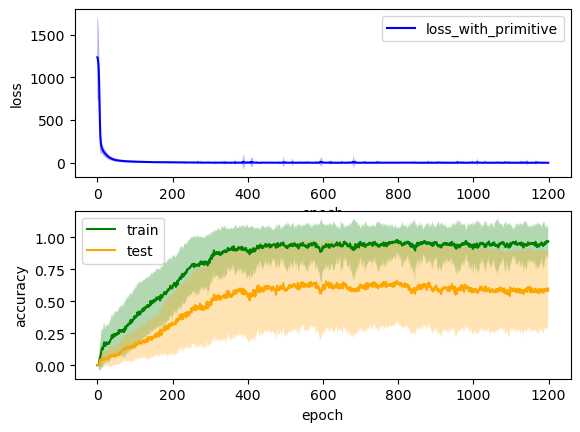

<Figure size 640x480 with 0 Axes>

In [18]:
# other
trainseqs = generate_other(ops, ['A', 'B'])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res6 = run_plot(trainseqs, testseqs, cue_dict)
df6 = res6['df_trials']
df6

# 3 inputs

trainseqs  [['A', ('+', 'A'), '=', 8], ['B', ('+', 'A'), '=', 10], ['C', ('+', 'A'), '=', 11], ['A', '=', 4], ['B', '=', 6], ['C', '=', 7], ['D', '=', 9]]
testseqs  [['A', ('+', 'B'), '=', 10], ['A', ('+', 'C'), '=', 11], ['A', ('+', 'D'), '=', 13], ['B', ('+', 'B'), '=', 12], ['B', ('+', 'C'), '=', 13], ['B', ('+', 'D'), '=', 15], ['C', ('+', 'B'), '=', 13], ['C', ('+', 'C'), '=', 14], ['C', ('+', 'D'), '=', 16], ['D', ('+', 'A'), '=', 13], ['D', ('+', 'B'), '=', 15], ['D', ('+', 'C'), '=', 16], ['D', ('+', 'D'), '=', 18]]
run time:  6.500553651650747
88
total time:  6.5188558340072635
88 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.69 
-----------



,label,pred,acc
trial,,,
"['D', '+', 'A', '=']",17.806818,17.683784,0.806818
"['A', '+', 'C', '=']",18.863636,18.648154,0.772727
"['A', '+', 'B', '=']",18.295455,18.055446,0.761364
"['C', '+', 'C', '=']",19.727273,19.177859,0.761364
"['B', '+', 'C', '=']",19.159091,18.812903,0.750000
"['B', '+', 'B', '=']",18.590909,18.015068,0.738636
"['C', '+', 'B', '=']",19.159091,18.793549,0.738636
"['D', '+', 'C', '=']",18.670455,18.068192,0.647727
"['D', '+', 'B', '=']",18.102273,17.498866,0.625000


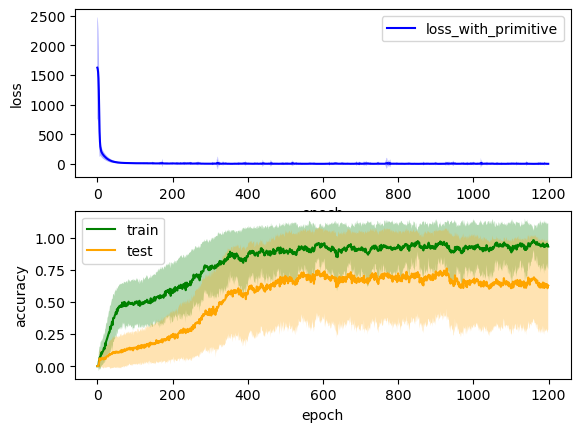

<Figure size 640x480 with 0 Axes>

In [20]:
# row
trainseqs = generate_trials(ops, ['A'], ['A', 'B', 'C'])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res7 = run_plot(trainseqs, testseqs, cue_dict)
df7= res7['df_trials']
df7

trainseqs  [['A', ('+', 'A'), '=', 8], ['A', ('+', 'B'), '=', 10], ['A', ('+', 'C'), '=', 11], ['A', '=', 4], ['B', '=', 6], ['C', '=', 7], ['D', '=', 9]]
testseqs  [['A', ('+', 'D'), '=', 13], ['B', ('+', 'A'), '=', 10], ['B', ('+', 'B'), '=', 12], ['B', ('+', 'C'), '=', 13], ['B', ('+', 'D'), '=', 15], ['C', ('+', 'A'), '=', 11], ['C', ('+', 'B'), '=', 13], ['C', ('+', 'C'), '=', 14], ['C', ('+', 'D'), '=', 16], ['D', ('+', 'A'), '=', 13], ['D', ('+', 'B'), '=', 15], ['D', ('+', 'C'), '=', 16], ['D', ('+', 'D'), '=', 18]]
run time:  9.11876846551895
91
total time:  9.136788650353749
91 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.09 
-----------



,label,pred,acc
trial,,,
"['A', '+', 'D', '=']",18.703297,18.625339,0.868132
"['C', '+', 'D', '=']",19.043956,23.714403,0.054945
"['B', '+', 'D', '=']",19.439560,25.259148,0.032967
"['D', '+', 'A', '=']",18.703297,22.245291,0.032967
"['D', '+', 'B', '=']",19.439560,22.971901,0.032967
"['D', '+', 'C', '=']",19.043956,22.591539,0.032967
"['D', '+', 'D', '=']",18.131868,21.592435,0.032967
"['C', '+', 'A', '=']",19.615385,24.357953,0.021978
"['C', '+', 'B', '=']",20.351648,25.084016,0.021978


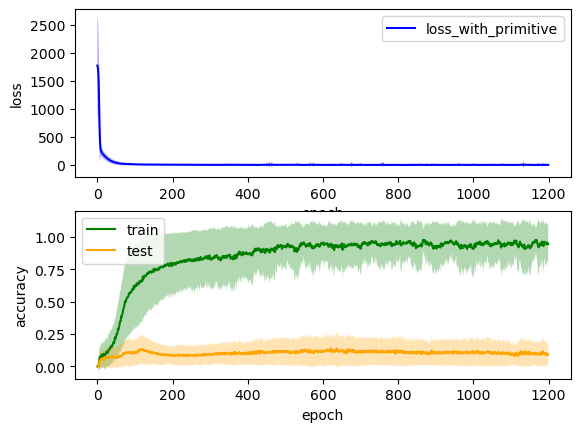

<Figure size 640x480 with 0 Axes>

In [21]:
# col
trainseqs = generate_trials(ops, ['A', 'B', 'C'], ['A'])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res8 = run_plot(trainseqs, testseqs, cue_dict)
df8 = res8['df_trials']
df8

trainseqs  [['A', ('+', 'A'), '=', 8], ['B', ('+', 'B'), '=', 12], ['C', ('+', 'C'), '=', 14], ['A', '=', 4], ['B', '=', 6], ['C', '=', 7], ['D', '=', 9]]
testseqs  [['A', ('+', 'B'), '=', 10], ['A', ('+', 'C'), '=', 11], ['A', ('+', 'D'), '=', 13], ['B', ('+', 'A'), '=', 10], ['B', ('+', 'C'), '=', 13], ['B', ('+', 'D'), '=', 15], ['C', ('+', 'A'), '=', 11], ['C', ('+', 'B'), '=', 13], ['C', ('+', 'D'), '=', 16], ['D', ('+', 'A'), '=', 13], ['D', ('+', 'B'), '=', 15], ['D', ('+', 'C'), '=', 16], ['D', ('+', 'D'), '=', 18]]
run time:  5.289813915888469
79
total time:  5.297776182492574
79 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.73 
-----------



,label,pred,acc
trial,,,
"['B', '+', 'A', '=']",18.291139,18.396062,0.822785
"['C', '+', 'A', '=']",18.379747,18.668067,0.822785
"['A', '+', 'B', '=']",18.291139,18.322200,0.810127
"['A', '+', 'C', '=']",18.379747,18.221617,0.797468
"['B', '+', 'C', '=']",18.924051,18.821713,0.759494
"['C', '+', 'B', '=']",18.924051,19.179645,0.746835
"['D', '+', 'B', '=']",19.303797,19.442480,0.708861
"['D', '+', 'C', '=']",19.392405,19.391796,0.696203
"['A', '+', 'D', '=']",18.759494,18.623435,0.683544


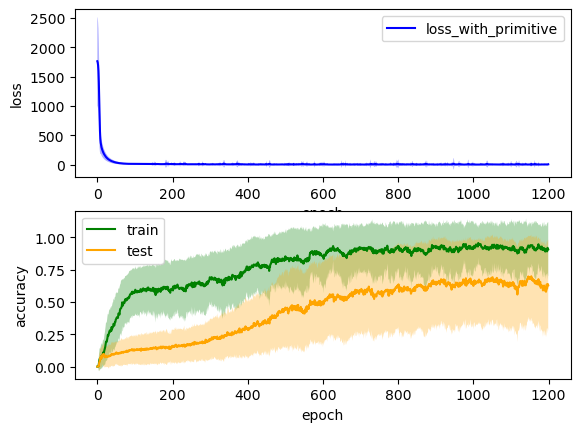

<Figure size 640x480 with 0 Axes>

In [22]:
# self
trainseqs = generate_self(ops, ['A', 'B', 'C'])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res9 = run_plot(trainseqs, testseqs, cue_dict)
df9 = res9['df_trials']
df9

trainseqs  [['A', ('+', 'B'), '=', 10], ['B', ('+', 'C'), '=', 13], ['C', ('+', 'A'), '=', 11], ['A', '=', 4], ['B', '=', 6], ['C', '=', 7], ['D', '=', 9]]
testseqs  [['A', ('+', 'A'), '=', 8], ['A', ('+', 'C'), '=', 11], ['A', ('+', 'D'), '=', 13], ['B', ('+', 'A'), '=', 10], ['B', ('+', 'B'), '=', 12], ['B', ('+', 'D'), '=', 15], ['C', ('+', 'B'), '=', 13], ['C', ('+', 'C'), '=', 14], ['C', ('+', 'D'), '=', 16], ['D', ('+', 'A'), '=', 13], ['D', ('+', 'B'), '=', 15], ['D', ('+', 'C'), '=', 16], ['D', ('+', 'D'), '=', 18]]
run time:  5.520029966036478
80
total time:  5.534565353393555
80 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.79 
-----------



,label,pred,acc
trial,,,
"['A', '+', 'A', '=']",18.5000,18.385982,0.8625
"['A', '+', 'C', '=']",18.1250,18.093993,0.8625
"['C', '+', 'B', '=']",18.2125,18.149947,0.8625
"['B', '+', 'B', '=']",18.6750,18.588974,0.8500
"['B', '+', 'A', '=']",18.5875,18.539493,0.8250
"['C', '+', 'C', '=']",17.7500,17.552285,0.8125
"['D', '+', 'C', '=']",18.1250,17.934030,0.8000
"['A', '+', 'D', '=']",18.5000,18.411076,0.7875
"['B', '+', 'D', '=']",18.5875,18.473508,0.7750


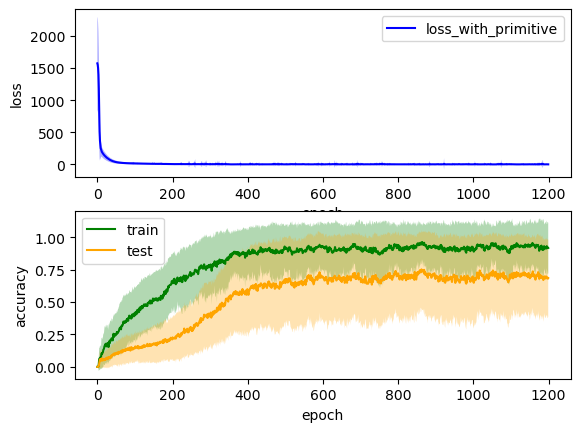

<Figure size 640x480 with 0 Axes>

In [35]:
# other
trainseqs = generate_other(ops, ['A', 'B', 'C'])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res10 = run_plot(trainseqs, testseqs, cue_dict)
df10 = res10['df_trials']
df10

trainseqs  [['A', ('+', 'A'), '=', 8], ['B', ('+', 'A'), '=', 10], ['C', ('+', 'B'), '=', 13], ['A', '=', 4], ['B', '=', 6], ['C', '=', 7], ['D', '=', 9]]
testseqs  [['A', ('+', 'B'), '=', 10], ['A', ('+', 'C'), '=', 11], ['A', ('+', 'D'), '=', 13], ['B', ('+', 'B'), '=', 12], ['B', ('+', 'C'), '=', 13], ['B', ('+', 'D'), '=', 15], ['C', ('+', 'A'), '=', 11], ['C', ('+', 'C'), '=', 14], ['C', ('+', 'D'), '=', 16], ['D', ('+', 'A'), '=', 13], ['D', ('+', 'B'), '=', 15], ['D', ('+', 'C'), '=', 16], ['D', ('+', 'D'), '=', 18]]
run time:  7.364958616097768
85
total time:  7.379326049486796
85 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.78 
-----------



,label,pred,acc
trial,,,
"['B', '+', 'B', '=']",17.552941,17.476441,0.952941
"['C', '+', 'A', '=']",17.823529,17.763713,0.941176
"['A', '+', 'B', '=']",18.023529,18.017538,0.917647
"['A', '+', 'C', '=']",17.823529,17.689099,0.800000
"['B', '+', 'C', '=']",17.352941,17.180994,0.788235
"['C', '+', 'C', '=']",17.152941,16.845096,0.764706
"['D', '+', 'A', '=']",19.705882,19.327831,0.764706
"['B', '+', 'D', '=']",19.235294,19.014855,0.752941
"['C', '+', 'D', '=']",19.035294,18.690180,0.752941


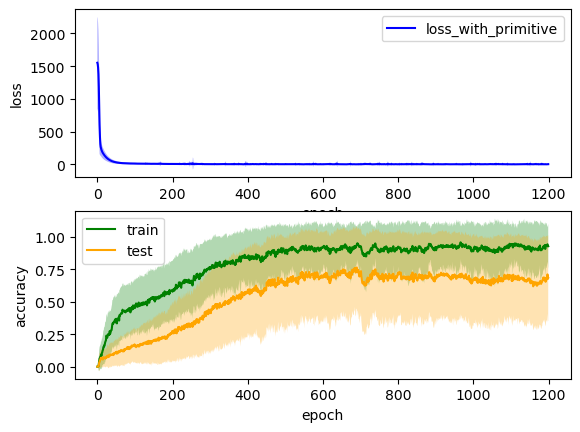

<Figure size 640x480 with 0 Axes>

In [36]:
# mixed
trainseqs = generate_trials(ops,['A'], all_syms[:-2] ) + generate_trials(ops, ['B'], all_syms[-2])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res11 = run_plot(trainseqs, testseqs, cue_dict)
df11 = res11['df_trials']
df11

trainseqs  [['A', ('+', 'A'), '=', 8], ['A', ('+', 'B'), '=', 10], ['A', ('+', 'C'), '=', 11], ['B', ('+', 'A'), '=', 10], ['B', ('+', 'B'), '=', 12], ['B', ('+', 'C'), '=', 13], ['C', ('+', 'A'), '=', 11], ['C', ('+', 'B'), '=', 13], ['C', ('+', 'C'), '=', 14], ['A', '=', 4], ['B', '=', 6], ['C', '=', 7], ['D', '=', 9]]
testseqs  [['A', ('+', 'D'), '=', 13], ['B', ('+', 'D'), '=', 15], ['C', ('+', 'D'), '=', 16], ['D', ('+', 'A'), '=', 13], ['D', ('+', 'B'), '=', 15], ['D', ('+', 'C'), '=', 16], ['D', ('+', 'D'), '=', 18]]
run time:  9.384567300478617
80
total time:  9.389265433947246
80 / 104  rnns trained to 100% accuracy.        
 Mean test acc =  0.77 
-----------



,label,pred,acc
trial,,,
"['D', '+', 'A', '=']",18.9375,18.749437,0.8500
"['D', '+', 'B', '=']",19.5250,19.337779,0.8375
"['D', '+', 'C', '=']",19.4000,19.205323,0.8375
"['A', '+', 'D', '=']",18.9375,18.643032,0.7375
"['B', '+', 'D', '=']",19.5250,19.248099,0.7250
"['C', '+', 'D', '=']",19.4000,19.148113,0.7250
"['D', '+', 'D', '=']",20.3000,19.783638,0.6750


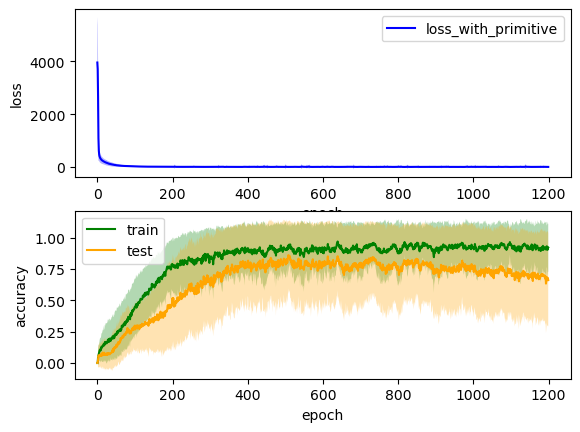

<Figure size 640x480 with 0 Axes>

In [37]:
# df all
trainseqs = generate_trials(ops, all_syms[:-1],  all_syms[:-1])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res12 = run_plot(trainseqs, testseqs, cue_dict)
df12 = res12['df_trials']
df12

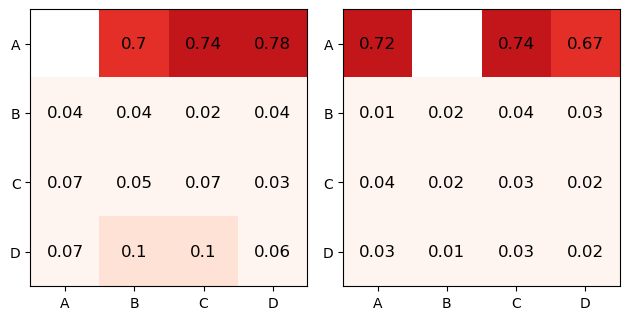

In [25]:
# plot 1
num_cols = 2
dfs = [df1, df2]
fig, axs = plt.subplots(1,2)
for i, df in enumerate(dfs):
    heatmap_acc(num_inputs, df, axs[i])

plt.tight_layout()    

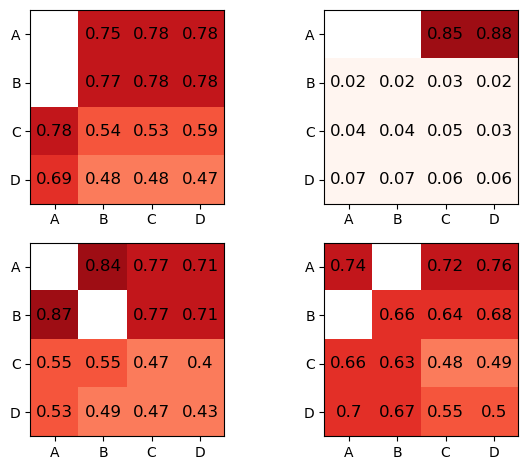

In [28]:
# plot 2
num_cols = 2
dfs = [df3, df4, df5, df6 ]
fig, axs = plt.subplots(2,2)
for i, df in enumerate(dfs):
    heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])

plt.tight_layout() 

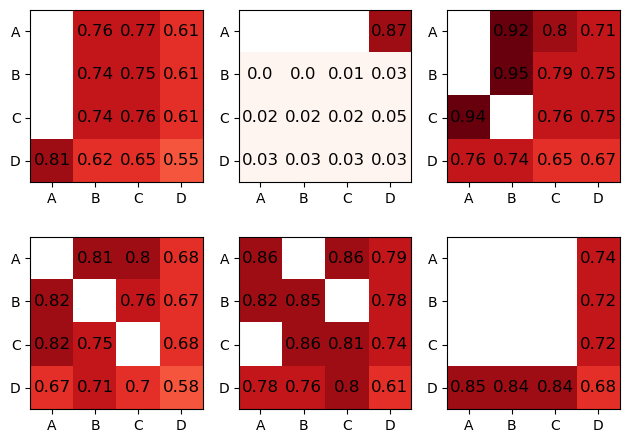

In [40]:
# plot 2
num_cols = 3
dfs = [df7, df8, df11, df9, df10,df12]
fig, axs = plt.subplots(2,3)
for i, df in enumerate(dfs):
    heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])

plt.tight_layout() 

In [75]:
df12[["'D'" in ind for ind in df12.index]].acc.mean()

0.7696428571428572

In [74]:
df7[["'D'" in ind for ind in df7.index]]

,label,pred,acc
trial,,,
"['D', '+', 'A', '=']",17.806818,17.683784,0.806818
"['D', '+', 'C', '=']",18.670455,18.068192,0.647727
"['D', '+', 'B', '=']",18.102273,17.498866,0.625000
"['A', '+', 'D', '=']",17.806818,17.427042,0.613636
"['B', '+', 'D', '=']",18.102273,17.560795,0.613636
"['C', '+', 'D', '=']",18.670455,18.110701,0.613636
"['D', '+', 'D', '=']",17.613636,16.762910,0.545455


In [65]:
# 4 inputs
# column
trainseqs = generate_trials(ops, ['A'], all_syms[:-2])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res12 = run_plot(trainseqs, testseqs, cue_dict)
df12 = res12['df_trials']
df12

trainseqs  [['A', ('+', 'A'), '=', 30], ['B', ('+', 'A'), '=', 18], ['A', '=', 15], ['B', '=', 3], ['C', '=', 13], ['D', '=', 17]]
testseqs  [['A', ('+', 'B'), '=', 18], ['A', ('+', 'C'), '=', 28], ['A', ('+', 'D'), '=', 32], ['B', ('+', 'B'), '=', 6], ['B', ('+', 'C'), '=', 16], ['B', ('+', 'D'), '=', 20], ['C', ('+', 'A'), '=', 28], ['C', ('+', 'B'), '=', 16], ['C', ('+', 'C'), '=', 26], ['C', ('+', 'D'), '=', 30], ['D', ('+', 'A'), '=', 32], ['D', ('+', 'B'), '=', 20], ['D', ('+', 'C'), '=', 30], ['D', ('+', 'D'), '=', 34]]
run time:  3.781916399796804
64
total time:  3.789011001586914
64 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.68 
-----------



,label,pred,acc
trial,,,
"['B', '+', 'B', '=']",18.40625,18.123862,0.875000
"['A', '+', 'B', '=']",19.03125,18.878617,0.843750
"['B', '+', 'C', '=']",18.68750,18.406014,0.781250
"['B', '+', 'D', '=']",18.31250,17.989101,0.765625
"['A', '+', 'C', '=']",19.31250,19.109970,0.750000
"['A', '+', 'D', '=']",18.93750,18.713371,0.750000
"['C', '+', 'A', '=']",19.31250,20.616629,0.734375
"['D', '+', 'A', '=']",18.93750,19.531570,0.687500
"['C', '+', 'B', '=']",18.68750,19.733772,0.625000


<Figure size 640x480 with 0 Axes>

In [64]:
# 4 inputs
# self
trainseqs = generate_self(ops, all_syms[:-2])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res9 = run_plot(trainseqs, testseqs, cue_dict)
df9 = res9['df_trials']
df9

trainseqs  [['A', ('+', 'A'), '=', 30], ['B', ('+', 'B'), '=', 6], ['A', '=', 15], ['B', '=', 3], ['C', '=', 13], ['D', '=', 17]]
testseqs  [['A', ('+', 'B'), '=', 18], ['A', ('+', 'C'), '=', 28], ['A', ('+', 'D'), '=', 32], ['B', ('+', 'A'), '=', 18], ['B', ('+', 'C'), '=', 16], ['B', ('+', 'D'), '=', 20], ['C', ('+', 'A'), '=', 28], ['C', ('+', 'B'), '=', 16], ['C', ('+', 'C'), '=', 26], ['C', ('+', 'D'), '=', 30], ['D', ('+', 'A'), '=', 32], ['D', ('+', 'B'), '=', 20], ['D', ('+', 'C'), '=', 30], ['D', ('+', 'D'), '=', 34]]
run time:  4.046347367763519
56
total time:  4.0527360200881954
56 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.64 
-----------



,label,pred,acc
trial,,,
"['A', '+', 'C', '=']",19.017857,18.945039,0.857143
"['A', '+', 'B', '=']",19.357143,19.407694,0.839286
"['B', '+', 'A', '=']",19.357143,19.393848,0.821429
"['B', '+', 'C', '=']",19.446429,19.353954,0.785714
"['A', '+', 'D', '=']",18.303571,18.139600,0.732143
"['B', '+', 'D', '=']",18.732143,18.597759,0.642857
"['C', '+', 'A', '=']",19.017857,19.867496,0.642857
"['C', '+', 'B', '=']",19.446429,20.287081,0.607143
"['C', '+', 'C', '=']",19.107143,19.869225,0.553571


<Figure size 640x480 with 0 Axes>

In [60]:
# 4 inputs
# other
trainseqs = generate_other(ops, all_syms[:-2])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res10 = run_plot(trainseqs, testseqs, cue_dict)
df10 = res10['df_trials']
df10

trainseqs  [['A', ('+', 'B'), '=', 18], ['B', ('+', 'A'), '=', 18], ['A', '=', 15], ['B', '=', 3], ['C', '=', 13], ['D', '=', 17]]
testseqs  [['A', ('+', 'A'), '=', 30], ['A', ('+', 'C'), '=', 28], ['A', ('+', 'D'), '=', 32], ['B', ('+', 'B'), '=', 6], ['B', ('+', 'C'), '=', 16], ['B', ('+', 'D'), '=', 20], ['C', ('+', 'A'), '=', 28], ['C', ('+', 'B'), '=', 16], ['C', ('+', 'C'), '=', 26], ['C', ('+', 'D'), '=', 30], ['D', ('+', 'A'), '=', 32], ['D', ('+', 'B'), '=', 20], ['D', ('+', 'C'), '=', 30], ['D', ('+', 'D'), '=', 34]]
run time:  3.9699116508165995
71
total time:  3.9838318983713785
71 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.62 
-----------



,label,pred,acc
trial,,,
"['B', '+', 'B', '=']",19.380282,19.034771,0.732394
"['A', '+', 'A', '=']",18.929577,18.583258,0.718310
"['A', '+', 'D', '=']",18.971831,18.740232,0.690141
"['B', '+', 'C', '=']",18.450704,18.192155,0.676056
"['C', '+', 'B', '=']",18.450704,18.163804,0.661972
"['A', '+', 'C', '=']",18.225352,17.949875,0.647887
"['D', '+', 'B', '=']",19.197183,18.938506,0.647887
"['B', '+', 'D', '=']",19.197183,18.962567,0.633803
"['D', '+', 'A', '=']",18.971831,18.680473,0.633803


<Figure size 640x480 with 0 Axes>

In [61]:
# 4 inputs
# all
trainseqs = generate_trials(ops, all_syms[:-2], all_syms[:-2])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res11 = run_plot(trainseqs, testseqs, cue_dict)
df11 = res11['df_trials']
df11

trainseqs  [['A', ('+', 'A'), '=', 30], ['A', ('+', 'B'), '=', 18], ['B', ('+', 'A'), '=', 18], ['B', ('+', 'B'), '=', 6], ['A', '=', 15], ['B', '=', 3], ['C', '=', 13], ['D', '=', 17]]
testseqs  [['A', ('+', 'C'), '=', 28], ['A', ('+', 'D'), '=', 32], ['B', ('+', 'C'), '=', 16], ['B', ('+', 'D'), '=', 20], ['C', ('+', 'A'), '=', 28], ['C', ('+', 'B'), '=', 16], ['C', ('+', 'C'), '=', 26], ['C', ('+', 'D'), '=', 30], ['D', ('+', 'A'), '=', 32], ['D', ('+', 'B'), '=', 20], ['D', ('+', 'C'), '=', 30], ['D', ('+', 'D'), '=', 34]]
run time:  8.351642167568206
72
total time:  8.366729919115702
72 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.64 
-----------



,label,pred,acc
trial,,,
"['A', '+', 'D', '=']",18.638889,18.410117,0.833333
"['B', '+', 'D', '=']",19.305556,19.078792,0.805556
"['A', '+', 'C', '=']",19.555556,19.342837,0.763889
"['B', '+', 'C', '=']",20.222222,20.007671,0.750000
"['D', '+', 'A', '=']",18.638889,18.180396,0.652778
"['C', '+', 'A', '=']",19.555556,19.025648,0.638889
"['D', '+', 'B', '=']",19.305556,18.827816,0.638889
"['C', '+', 'B', '=']",20.222222,19.678631,0.625000
"['C', '+', 'D', '=']",20.027778,19.185522,0.527778


<Figure size 640x480 with 0 Axes>

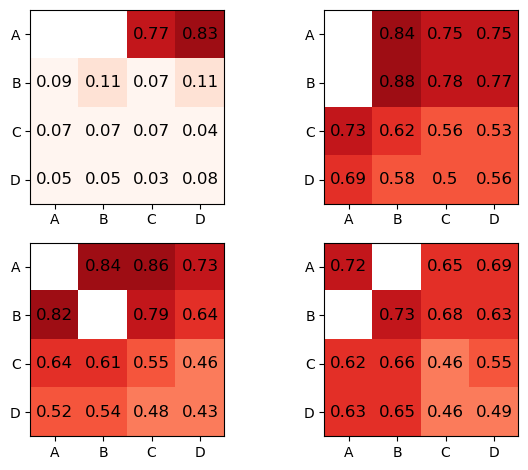

In [70]:
num_cols = 2
dfs = [df8, df12, df9, df10]
fig, axs = plt.subplots(2,2)
for i, df in enumerate(dfs):
    heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])

plt.tight_layout()    

In [76]:
# 4 inputs
# column
trainseqs = generate_trials(ops, all_syms[:-1], ['A'])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res1 = run_plot(trainseqs, testseqs, cue_dict)
df1 = res1['df_trials']
df1

In [ ]:
# all other
trainseqs = generate_other(ops, all_syms[:-1])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res2 = run_plot(trainseqs, testseqs, cue_dict)
df2 = res2['df_trials']
df2

In [ ]:
# all self
trainseqs = generate_self(ops, all_syms[:-1])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res3 = run_plot(trainseqs, testseqs, cue_dict)
df3 = res3['df_trials']
df3

In [ ]:
## all
trainseqs = generate_trials(ops, all_syms[:-1], all_syms[:-1])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res4 = run_plot(trainseqs, testseqs, cue_dict)
df4 = res4['df_trials']
df4


In [ ]:
#
trainseqs = generate_trials(ops, ['A'], all_syms[:-1])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res5 = run_plot(trainseqs, testseqs, cue_dict)
df5 = res5['df_trials']
df5

In [ ]:
#
trainseqs = generate_trials(ops, ['A'], ['A', 'C']) + generate_trials(ops, ['C'], ['B']) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res6 = run_plot(trainseqs, testseqs, cue_dict)
df6 = res6['df_trials']
df6

In [ ]:
dfs = [df1, df2 , df3, df5, df6, df4]

num_cols = 3
fig, axs = plt.subplots(2,3)
for i, df in enumerate(dfs):
    heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])
    plt.tight_layout()    

In [ ]:
####### see if can extrapolate to more ....

In [48]:
ops = '+'

num_inputs = 5
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
p = generate_primitives(all_syms)
print(p)

{'A': 3, 'B': 8, 'C': 6, 'D': 4, 'E': 14}
[['A', '=', 3], ['B', '=', 8], ['C', '=', 6], ['D', '=', 4], ['E', '=', 14]]


In [49]:
trainseqs = generate_other(ops, all_syms[:-2]) + generate_other(ops, all_syms[:-2]) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res6 = run_plot(trainseqs, testseqs, cue_dict)
df6 = res6['df_trials']
df6

trainseqs  [['A', ('+', 'B'), '=', 11], ['B', ('+', 'C'), '=', 14], ['C', ('+', 'A'), '=', 9], ['A', ('+', 'B'), '=', 11], ['B', ('+', 'C'), '=', 14], ['C', ('+', 'A'), '=', 9], ['A', '=', 3], ['B', '=', 8], ['C', '=', 6], ['D', '=', 4], ['E', '=', 14]]
testseqs  [['A', ('+', 'A'), '=', 6], ['A', ('+', 'C'), '=', 9], ['A', ('+', 'D'), '=', 7], ['A', ('+', 'E'), '=', 17], ['B', ('+', 'A'), '=', 11], ['B', ('+', 'B'), '=', 16], ['B', ('+', 'D'), '=', 12], ['B', ('+', 'E'), '=', 22], ['C', ('+', 'B'), '=', 14], ['C', ('+', 'C'), '=', 12], ['C', ('+', 'D'), '=', 10], ['C', ('+', 'E'), '=', 20], ['D', ('+', 'A'), '=', 7], ['D', ('+', 'B'), '=', 12], ['D', ('+', 'C'), '=', 10], ['D', ('+', 'D'), '=', 8], ['D', ('+', 'E'), '=', 18], ['E', ('+', 'A'), '=', 17], ['E', ('+', 'B'), '=', 22], ['E', ('+', 'C'), '=', 20], ['E', ('+', 'D'), '=', 18], ['E', ('+', 'E'), '=', 28]]
run time:  17.939850930372874
87
total time:  17.969373377164207
87 / 104  rnns trained to 100% accuracy.        
 Mean test

,label,pred,acc
trial,,,
"['A', '+', 'A', '=']",18.183908,18.037512,0.839080
"['A', '+', 'C', '=']",18.586207,18.442758,0.816092
"['B', '+', 'B', '=']",18.850575,18.585532,0.793103
"['C', '+', 'B', '=']",18.919540,18.741767,0.781609
"['B', '+', 'A', '=']",18.517241,18.394962,0.770115
"['C', '+', 'C', '=']",18.988506,18.784154,0.770115
"['D', '+', 'C', '=']",18.666667,18.261323,0.724138
"['D', '+', 'A', '=']",18.264368,17.927418,0.712644
"['D', '+', 'B', '=']",18.597701,18.241316,0.712644


<Figure size 640x480 with 0 Axes>

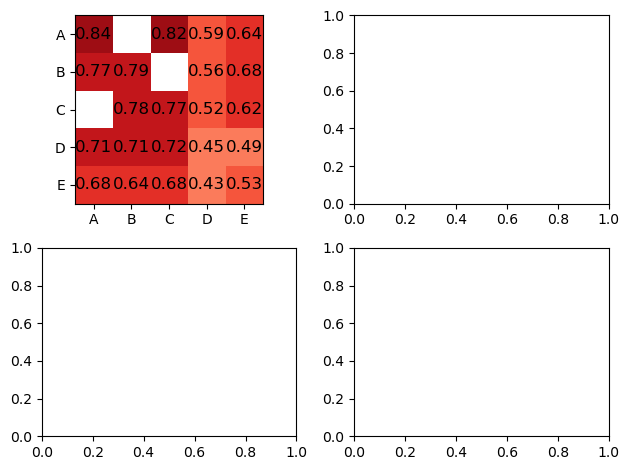

In [53]:
dfs = [df6]

num_cols = 1
fig, axs = plt.subplots(2,2)
for i, df in enumerate(dfs):
    heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])
    plt.tight_layout()    

## Num inputs = 2

In [14]:
ops = '+'

num_inputs = 2
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
#p = generate_primitives(['A','B'])
p = []
print(p)

{'A': 9, 'B': 11}
[]


trainseqs:  [['A', ('+', 'A'), '=', 18]]
testseqs:  [['A', ('+', 'B'), '=', 20], ['B', ('+', 'A'), '=', 20], ['B', ('+', 'B'), '=', 22]]
run time:  1.555055284500122
80
total time:  1.558457883199056
80 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.02 
-----------

trainseqs:  [['A', ('+', 'B'), '=', 20]]
testseqs:  [['A', ('+', 'A'), '=', 18], ['B', ('+', 'A'), '=', 20], ['B', ('+', 'B'), '=', 22]]
run time:  1.3551305452982585
80
total time:  1.3585744619369506
80 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.14 
-----------

trainseqs:  [['B', ('+', 'A'), '=', 20]]
testseqs:  [['A', ('+', 'A'), '=', 18], ['A', ('+', 'B'), '=', 20], ['B', ('+', 'B'), '=', 22]]
run time:  1.367291231950124
80
total time:  1.3709447344144186
80 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.1 
-----------

trainseqs:  [['B', ('+', 'B'), '=', 22]]
testseqs:  [['A', ('+', 'A'), '=', 18], ['A', ('+', 'B'), '=', 20], ['B', ('+', 'A'), '=', 20]]
run ti

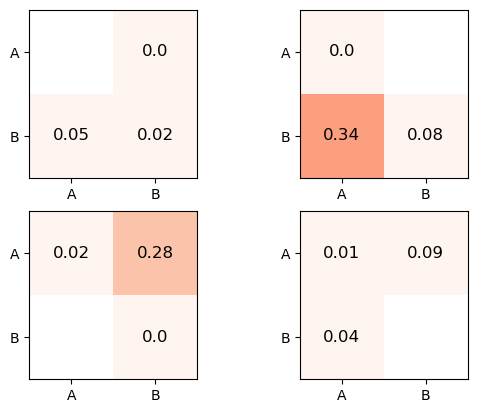

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [15]:
## 1 trials
num_train = 1

all_trials = generate_trials(ops, all_syms, all_syms)
trial_combos = list(itertools.combinations(all_trials, r=num_train))
train_trials = [trial for trial in trial_combos]

num_cols = 2
fig, axs = plt.subplots(math.ceil(len(train_trials)/num_cols), num_cols)
for i in range(len(train_trials)):
    trainseqs = list(train_trials[i]) + p
    testseqs = generate_trials(ops, all_syms, all_syms)
    testseqs = [s for s in testseqs if s not in trainseqs]
    print('trainseqs: ', trainseqs)
    print('testseqs: ', testseqs)
    res = run_plot(trainseqs, testseqs, cue_dict)
    df = res['df_trials']
    heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])
plt.tight_layout()    

trainseqs:  [['A', ('+', 'A'), '=', 18], ['A', ('+', 'B'), '=', 20]]
testseqs:  [['B', ('+', 'A'), '=', 20], ['B', ('+', 'B'), '=', 22]]
run time:  1.8155668179194133
80
total time:  1.8178449352582295
80 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.0 
-----------

trainseqs:  [['A', ('+', 'A'), '=', 18], ['B', ('+', 'A'), '=', 20]]
testseqs:  [['A', ('+', 'B'), '=', 20], ['B', ('+', 'B'), '=', 22]]
run time:  1.7716371655464171
80
total time:  1.7744565963745118
80 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.0 
-----------

trainseqs:  [['A', ('+', 'A'), '=', 18], ['B', ('+', 'B'), '=', 22]]
testseqs:  [['A', ('+', 'B'), '=', 20], ['B', ('+', 'A'), '=', 20]]
run time:  1.7899619221687317
80
total time:  1.7925228198369345
80 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.05 
-----------

trainseqs:  [['A', ('+', 'B'), '=', 20], ['B', ('+', 'A'), '=', 20]]
testseqs:  [['A', ('+', 'A'), '=', 18], ['B', ('+', 'B'), '=', 22]]
run 

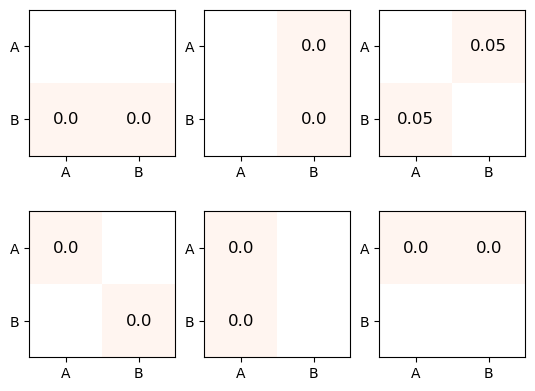

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [16]:
## 2 trials
num_train = 2

all_trials = generate_trials(ops, all_syms, all_syms)
trial_combos = list(itertools.combinations(all_trials, r=num_train))
train_trials = [trial for trial in trial_combos]

num_cols = 3
fig, axs = plt.subplots(math.ceil(len(train_trials)/num_cols), num_cols)
for i in range(len(train_trials)):
    trainseqs = list(train_trials[i]) + p
    testseqs = generate_trials(ops, all_syms, all_syms)
    testseqs = [s for s in testseqs if s not in trainseqs]
    print('trainseqs: ', trainseqs)
    print('testseqs: ', testseqs)
    res = run_plot(trainseqs, testseqs, cue_dict)
    df = res['df_trials']
    heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])
plt.tight_layout()    

trainseqs:  [['A', ('+', 'A'), '=', 18], ['A', ('+', 'B'), '=', 20], ['B', ('+', 'A'), '=', 20]]
testseqs:  [['B', ('+', 'B'), '=', 22]]
run time:  2.154658397038778
50
total time:  2.155635444323222
50 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.88 
-----------

trainseqs:  [['A', ('+', 'A'), '=', 18], ['A', ('+', 'B'), '=', 20], ['B', ('+', 'B'), '=', 22]]
testseqs:  [['B', ('+', 'A'), '=', 20]]
run time:  2.038174569606781
50
total time:  2.039296253522237
50 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.58 
-----------

trainseqs:  [['A', ('+', 'A'), '=', 18], ['B', ('+', 'A'), '=', 20], ['B', ('+', 'B'), '=', 22]]
testseqs:  [['A', ('+', 'B'), '=', 20]]
run time:  1.1173688491185507
48
total time:  1.118294616540273
48 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.56 
-----------

trainseqs:  [['A', ('+', 'B'), '=', 20], ['B', ('+', 'A'), '=', 20], ['B', ('+', 'B'), '=', 22]]
testseqs:  [['A', ('+', 'A'), '=', 18]]
run tim

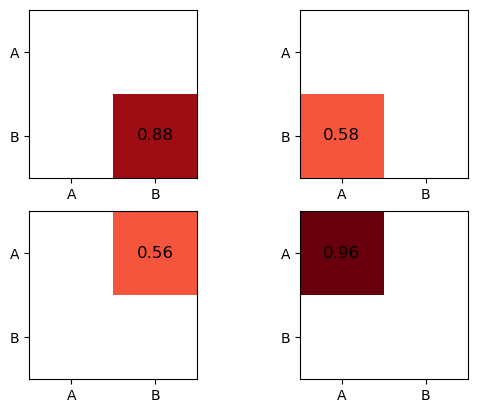

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [17]:
## 3 trials
num_train = 3

all_trials = generate_trials(ops, all_syms, all_syms)
trial_combos = list(itertools.combinations(all_trials, r=num_train))
train_trials = [trial for trial in trial_combos]

num_cols = 2
fig, axs = plt.subplots(math.ceil(len(train_trials)/num_cols), num_cols)
for i in range(len(train_trials)):
    trainseqs = list(train_trials[i]) + p
    testseqs = generate_trials(ops, all_syms, all_syms)
    testseqs = [s for s in testseqs if s not in trainseqs]
    print('trainseqs: ', trainseqs)
    print('testseqs: ', testseqs)
    res = run_plot(trainseqs, testseqs, cue_dict)
    df = res['df_trials']
    heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])
plt.tight_layout()    

## Num inputs = 3

In [18]:
ops = '+'

num_inputs = 3
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
p = generate_primitives(all_syms)
#p = []
print(p)

{'A': 12, 'B': 9, 'C': 11}
[['A', '=', 12], ['B', '=', 9], ['C', '=', 11]]


trainseqs:  [['A', ('+', 'A'), '=', 24], ['A', '=', 12], ['B', '=', 9], ['C', '=', 11]]
testseqs:  [['A', ('+', 'B'), '=', 21], ['A', ('+', 'C'), '=', 23], ['B', ('+', 'A'), '=', 21], ['B', ('+', 'B'), '=', 18], ['B', ('+', 'C'), '=', 20], ['C', ('+', 'A'), '=', 23], ['C', ('+', 'B'), '=', 20], ['C', ('+', 'C'), '=', 22]]
run time:  3.4533602158228556
70
total time:  3.4597915689150494
70 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.25 
-----------

trainseqs:  [['A', ('+', 'B'), '=', 21], ['A', '=', 12], ['B', '=', 9], ['C', '=', 11]]
testseqs:  [['A', ('+', 'A'), '=', 24], ['A', ('+', 'C'), '=', 23], ['B', ('+', 'A'), '=', 21], ['B', ('+', 'B'), '=', 18], ['B', ('+', 'C'), '=', 20], ['C', ('+', 'A'), '=', 23], ['C', ('+', 'B'), '=', 20], ['C', ('+', 'C'), '=', 22]]
run time:  3.62475403547287
75
total time:  3.6363603353500364
75 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.21 
-----------

trainseqs:  [['A', ('+', 'C'), '=', 23], ['A', '=', 12

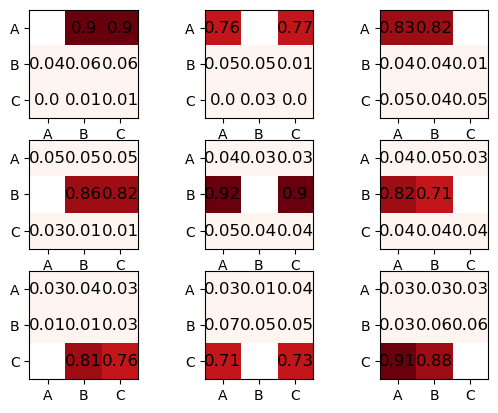

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [19]:
## 1 trials
num_train = 1

all_trials = generate_trials(ops, all_syms, all_syms)
trial_combos = list(itertools.combinations(all_trials, r=num_train))
train_trials = [trial for trial in trial_combos]

num_cols = 3
fig, axs = plt.subplots(math.ceil(len(train_trials)/num_cols), num_cols)
for i in range(len(train_trials)):
    trainseqs = list(train_trials[i]) + p
    testseqs = generate_trials(ops, all_syms, all_syms)
    testseqs = [s for s in testseqs if s not in trainseqs]
    print('trainseqs: ', trainseqs)
    print('testseqs: ', testseqs)
    res = run_plot(trainseqs, testseqs, cue_dict)
    df = res['df_trials']
    heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])
plt.tight_layout()    

In [23]:
train_trials1 = train_trials[:9]
train_trials2 = train_trials[9:18]
train_trials3 = train_trials[18:27]
train_trials4 = train_trials[27:]


trainseqs:  [['A', ('+', 'A'), '=', 24], ['A', ('+', 'B'), '=', 21], ['A', '=', 12], ['B', '=', 9], ['C', '=', 11]]
testseqs:  [['A', ('+', 'C'), '=', 23], ['B', ('+', 'A'), '=', 21], ['B', ('+', 'B'), '=', 18], ['B', ('+', 'C'), '=', 20], ['C', ('+', 'A'), '=', 23], ['C', ('+', 'B'), '=', 20], ['C', ('+', 'C'), '=', 22]]
run time:  4.283839213848114
75
total time:  4.2915126323699955
75 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.14 
-----------

trainseqs:  [['A', ('+', 'A'), '=', 24], ['A', ('+', 'C'), '=', 23], ['A', '=', 12], ['B', '=', 9], ['C', '=', 11]]
testseqs:  [['A', ('+', 'B'), '=', 21], ['B', ('+', 'A'), '=', 21], ['B', ('+', 'B'), '=', 18], ['B', ('+', 'C'), '=', 20], ['C', ('+', 'A'), '=', 23], ['C', ('+', 'B'), '=', 20], ['C', ('+', 'C'), '=', 22]]
run time:  4.311656133333842
73
total time:  4.31987978219986
73 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.14 
-----------

trainseqs:  [['A', ('+', 'A'), '=', 24], ['B', ('+', 'A'

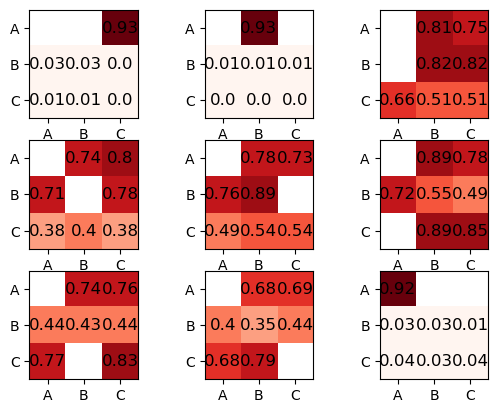

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [20]:
num_train = 2

all_trials = generate_trials(ops, all_syms, all_syms)
trial_combos = list(itertools.combinations(all_trials, r=num_train))
train_trials = [trial for trial in trial_combos]

train_trials1 = train_trials[:9]
train_trials2 = train_trials[9:18]
train_trials3 = train_trials[18:24]
train_trials4 = train_trials[24:]

fig, axs = plt.subplots(math.ceil(len(train_trials1)/num_cols), num_cols)
num_cols = 3
for i in range(len(train_trials1)):
    trainseqs = list(train_trials[i]) + p
    testseqs = generate_trials(ops, all_syms, all_syms)
    testseqs = [s for s in testseqs if s not in trainseqs]
    print('trainseqs: ', trainseqs)
    print('testseqs: ', testseqs)
    res = run_plot(trainseqs, testseqs, cue_dict)
    df = res['df_trials']
    heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])
plt.tight_layout()    

In [82]:
mods = [r['mod'] for r in res11['res']]

In [84]:
cm = mods[1]

In [97]:
cm.state_dict()['rnn.weight_ih_l0'][0,:]

tensor([-0.2086,  0.1062,  0.1132, -0.1217,  0.1454,  0.1716,  0.1947,  0.1639,
         0.0701,  0.1578,  0.0156, -0.0961, -0.0587, -0.1233, -0.1345, -0.1235,
        -0.0464, -0.1908, -0.1309, -0.1036,  0.2085,  0.1053])

In [94]:
onehot_dict = {0:'X',
                1:'Y',
                2:'A', 
                3:'B',
                4:'C',
                5:'D',
                6:'E', 
                7:'F',
                8:'G',
                9:'H',
                10:'I', 
                11:'J',
                12:'K',
                13:'L',
                14:'M', 
                15:'N',
                16:'O',
                17:'P',
                18:'+',
                19:'*',
                20:'-',
                21:'=',
                    }
          
